<a href="https://colab.research.google.com/github/stuart-lane/Chapter1/blob/main/DefaultDataLogit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ISLP

In [3]:
from ISLP import load_data

import pandas as pd
import numpy as np
import scipy
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
default = load_data("Default")

default['default1'] = (default['default'] == "Yes").astype(int)

<Axes: xlabel='balance', ylabel='income'>

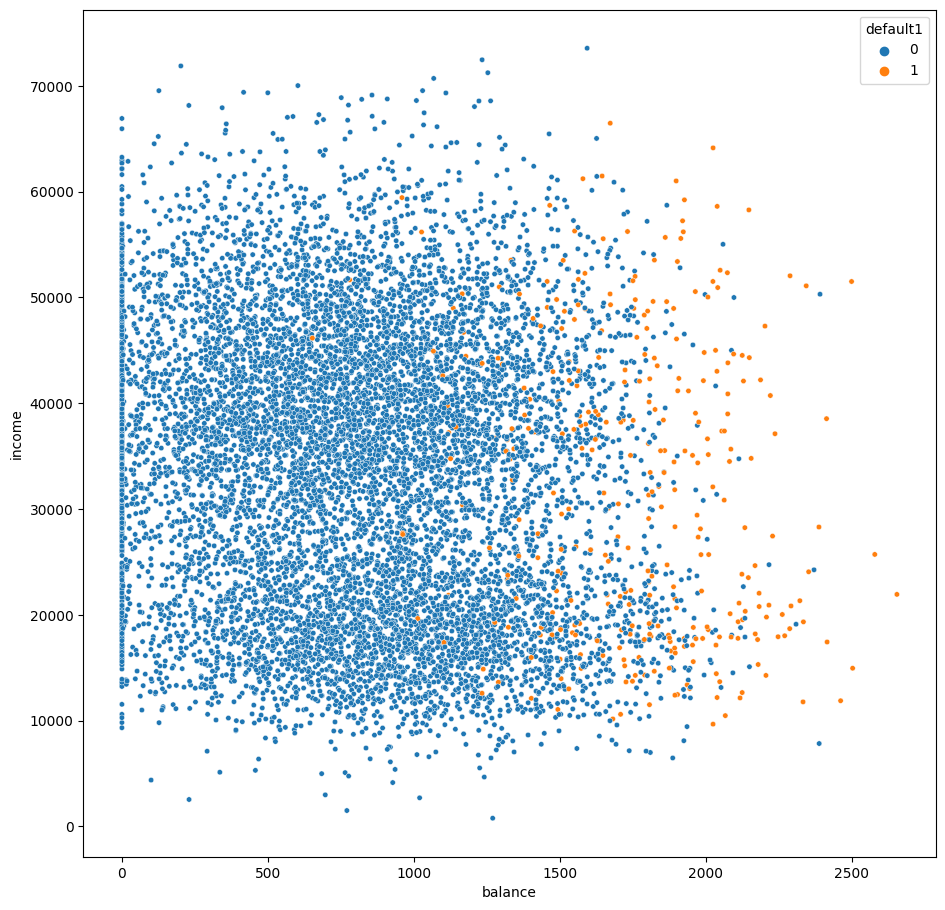

In [5]:
# Scatter plot of income and balance, hued by default

plt.figure(figsize = (11,11))
sns.scatterplot(data = default, x = 'balance', y = 'income', hue = 'default1', s = 15)

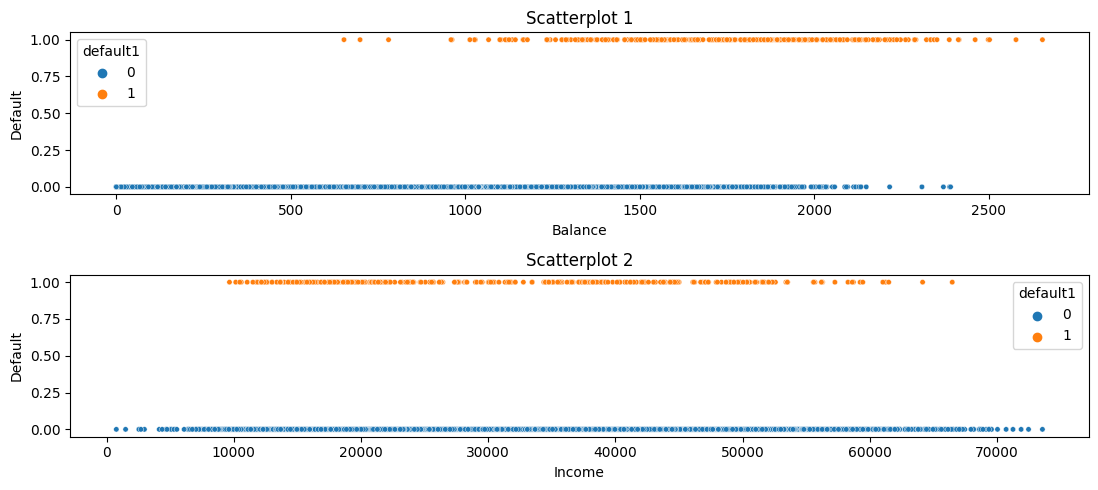

In [6]:
fig, axes = plt.subplots(2, 1, figsize = (11, 5))

sns.scatterplot(data = default, x = 'balance', y = 'default1', hue = 'default1', s = 15, ax = axes[0])
axes[0].set_title('Scatterplot 1')
axes[0].set_xlabel('Balance')
axes[0].set_ylabel('Default')

sns.scatterplot(data = default, x = 'income', y = 'default1', hue = 'default1', s = 15, ax = axes[1])
axes[1].set_title('Scatterplot 2')
axes[1].set_xlabel('Income')
axes[1].set_ylabel('Default')

plt.tight_layout()
plt.show()

## Maximum Likelihood Estimation
### Logistic Regression

Given predictors $x_i$, the posterior probability for class 1 is modeled using the logistic function:

$$ P_{\beta}(y_i = 1 | x_i) = \frac{e^{x_i' \beta}}{1 + e^{x_i' \beta}} =  \frac{1}{1 + e^{-x_i' \beta}}  $$

For a given observation $i$, if $y_i = 1$, then the contribution to the likelihood is $P_{\beta}(y_i = 1 | x_i)$. If $y_i = 0$, then the contribution is $1 - P_{\beta}(y_i = 1 | x_i)$.

This can be represented compactly as:

$$ L_i(\beta) = P_{\beta}(y_i = 1 | x_i)^{y_i} (1 - P_{\beta}(y_i = 1 | x_i))^{1-y_i} $$

### Likelihood Function

Given the data $(Y, x)$, the likelihood for the observed sample is the product of the individual likelihoods:

$$ L(\beta) = \prod_{i = 1}^n P_{\beta}(y_i = 1 | x_i)^{y_i} (1 - P_{\beta}(y_i = 1 | x_i))^{1- y_i} $$

### Log-Likelihood Function

Taking the natural logarithm, we obtain the log-likelihood:

$$ \log L(\beta) = \sum_i \left[ y_i \log P_{\beta}(y_i = 1 | x_i) + (1-y_i) \log (1 - P_{\beta}(y_i = 1 | x_i)) \right]. $$

### Derivative of LL (for Newton optimiser)


The log-likelihood function for logistic regression is given by:
$$
\log L(\beta) = \sum_i \left[ y_i \log P_{\beta}(y_i = 1 | \mathbf{x}_i) + (1-y_i) \log (1 - P_{\beta}(y_i = 1 | \mathbf{x}_i)) \right].
$$

The logistic function $ P_{\beta}(y_i = 1 | \mathbf{x}_i) $ is defined as:
$$
P_{\beta}(y_i = 1 | \mathbf{x}_i) = \frac{1}{1 + e^{-\mathbf{x}_i' \beta}}.
$$

**Step 1:** Compute the derivative of $P_{\beta}(y_i = 1 | \mathbf{x}_i) $ with respect to $\beta $
$$
\frac{\partial P_{\beta}}{\partial \beta} = \frac{e^{-\mathbf{x}_i' \beta} \times (-\mathbf{x}_i)}{(1 + e^{-\mathbf{x}_i' \beta})^2} = P_{\beta}(1 - P_{\beta}) \mathbf{x}_i.
$$

**Step 2:** Compute the derivative of the log-likelihood function with respect to $ \beta $.
We differentiate the $i$-th term in the summation with respect to $\beta$:
$$
\frac{\partial}{\partial \beta} \left( y_i \log P_{\beta} + (1-y_i) \log (1 - P_{\beta}) \right) = y_i \frac{1}{P_{\beta}} \frac{\partial P_{\beta}}{\partial \beta} + (1-y_i) \frac{-1}{1-P_{\beta}} \frac{\partial P_{\beta}}{\partial \beta}.
$$
Using the derivative from Step 1, this simplifies to:
$$
= y_i \frac{\mathbf{x}_i}{P_{\beta}} P_{\beta}(1 - P_{\beta}) - (1-y_i) \frac{\mathbf{x}_i}{1 - P_{\beta}} P_{\beta}(1 - P_{\beta}).
$$
Further simplification yields:
$$
= \mathbf{x}_i(y_i - P_{\beta}).
$$
**Step 3:** Sum over all \( i \) to get the gradient for the entire sample:
$$
\frac{\partial \log L(\beta)}{\partial \beta} = \sum_i \mathbf{x}_i (y_i - P_{\beta}(y_i = 1 | \mathbf{x}_i)).
$$

### Bayes Classifier
$$ \widehat{Y}_i = \mathbf{1}\left\{P_{\widehat{\beta}}(y_i = 1 | x_i)  \geq \frac{1}{2}\right\}$$

Dataset

In [27]:
from sklearn.model_selection import train_test_split

x = default[['balance', 'income']].values
x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
y = default['default1'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 123)
beta_initial = np.array([0, 0, 0])

In [28]:
def logistic(x, beta):
    x_beta = np.dot(x, beta)
    x_beta = np.clip(x_beta, -500, 500)
    return 1 / (1 + np.exp(-x_beta))

def log_likelihood(beta, x, y):
    p = logistic(x, beta)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    return -ll

beta_initial = np.array([0, 0, 0])
result = minimize(log_likelihood, beta_initial, args=(x_train, y_train), method='BFGS')

estimated_beta = [f'{param:.7f}' for param in result.x]
formatted_parameters = ', '.join(estimated_beta)

print(f"Estimated Parameters: [{formatted_parameters}]")
print("Negative Log-Likelihood:", result.fun)

Estimated Parameters: [-11.1711917, 0.0055521, 0.0000168]
Negative Log-Likelihood: 416.34389207458634


In [109]:
bhat_logistic = [float(bk) for bk in estimated_beta]

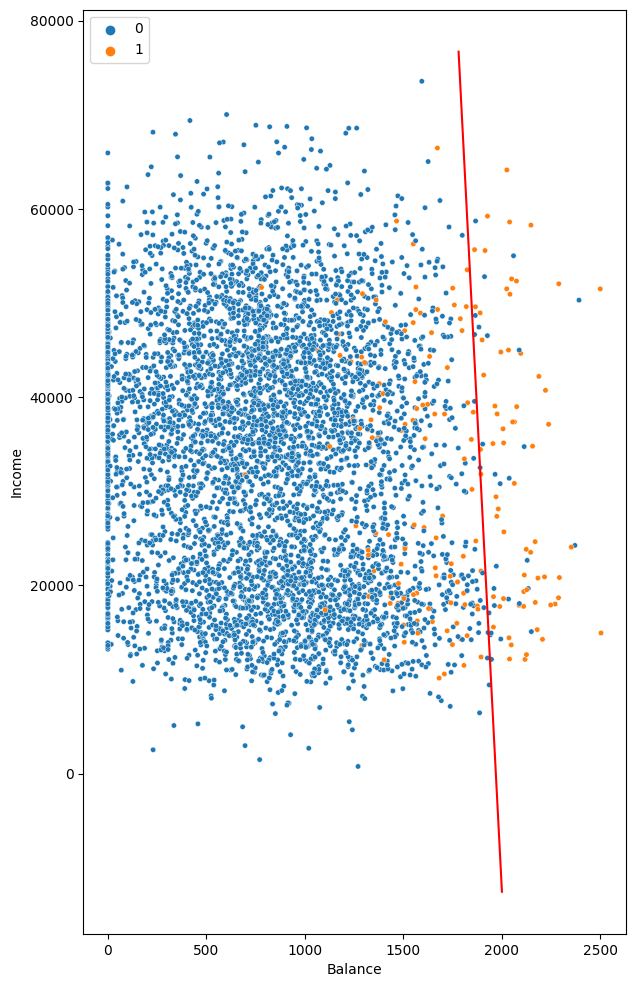

In [130]:
# Bayes decision boundary (BDB)
slope = -bhat_logistic[1]/bhat_logistic[2]
intercept = -bhat_logistic[0]/bhat_logistic[2]
x_grid = np.linspace(1780, 2000, 5000)
yhat_logistic = logistic(x_train, result.x)
bdb = [slope * xi + intercept for xi in x_grid]
bdb_logistic = np.array(bdb)
df2 = {'balance': x_train[:,1], 'income': x_train[:,2], 'default': y_train, 'est_probs_logit': yhat_logistic, 'bdb': bdb_array}
df2 = pd.DataFrame(df2)
df2 = pd.concat([df2, pd.DataFrame({'x_grid': x_grid})], axis = 1)

plt.figure(figsize = (7, 12))
sns.scatterplot(data = df2, x = 'balance', y = 'income', s = 15, hue = 'default')
sns.lineplot(data = df2, x = 'x_grid', y = 'bdb', color = 'red')

# Add labels and legend
plt.xlabel('Balance')
plt.ylabel('Income')
plt.legend(loc='upper left')

# Show the plot
plt.show()

AUTOGRAD LOGISTIC REGRESSION

In [14]:
import torch
from torch.optim import LBFGS

from IPython.display import display, HTML

In [32]:
train_df_keys = {'balance': x_train[:,1], 'income': x_train[:,2], 'default': y_train }

train_df = pd.DataFrame(train_df_keys)

In [99]:
x = torch.cat((torch.ones(train_df.shape[0], 1), torch.tensor(train_df[["balance", "income"]].values , dtype=torch.float64)), dim=1)
x.requires_grad = True

y = torch.tensor(train_df["default"].values, dtype = torch.float64)
y.requires_grad = True
y = y.view(-1, 1)

beta = torch.randn(3, 1, dtype = torch.float64)
beta.requires_grad = True

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"

print(f"Running on: {dev}")

Running on: cpu


In [100]:
beta = torch.zeros(3, 1, dtype=torch.float64, requires_grad = True)

# Define loss function: likelihood (binary cross-entropy in ML context)
def ll(beta):
    xbhat = torch.mm(x, beta)
    yhat = torch.sigmoid(xbhat)
    loss = -torch.sum(y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))
    return loss

# Using LBFGS optimizer
optimizer = LBFGS([beta], lr=0.001)

# A 'closure' for each step of the optimizer
def calc_loss():
    def closure():
        optimizer.zero_grad()
        value = ll(beta)
        value.backward()
        return value
    return closure

In [101]:
for i in range(1, 1001):
    logl = optimizer.step(calc_loss())
    logl_value = float(logl.detach().numpy())
    if i % 100 == 0:
      display(HTML("<tt>{0}: {1}</tt>".format(i, logl_value)))

In [129]:
bhat_autograd = beta.detach().numpy()
print(bhat_autograd)

slope = -bhat_autograd[1]/bhat_autograd[2]
intercept = -bhat_autograd[0]/bhat_autograd[2]
x_grid = np.linspace(1780, 2000, 5000)
yhat_autograd = logistic(x_train, result.x)
bdb = [slope * xi + intercept for xi in x_grid]
bdb_autograd = np.array(bdb)

[[-1.11727511e+01]
 [ 5.55230131e-03]
 [ 1.68387735e-05]]


NEURAL NETWORK LOGISTIC REGRESSION

In [41]:
import torch.nn as nn
import torch.nn.functional as F

In [96]:
x1x2 = torch.cat((torch.ones(len(train_df), 1), torch.tensor(train_df[["balance", "income"]].values) / 1000), dim=1)
y1 = torch.tensor(train_df['default'].values, dtype=torch.float32)

y = y1.clone().detach().requires_grad_(True)
x = x1x2[:, 1:].clone().detach().requires_grad_(True)  # no intercept, "bias" is explicit
x = x.to(torch.float)

# Define single-layer neural network (logistic regression)
class LogitModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogitModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Initialize model and optimizer
input_dim = x.size()[1]
output_dim = 1

net = LogitModel(input_dim, output_dim)
optimizer = optim.Adam(net.parameters(), lr = 0.01)

# Define the number of epochs and the loss function (assuming BCELoss)
epochs = 10000
loss_function = nn.BCELoss()

# Training loop
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    output = net(x)
    loss = loss_function(output.squeeze(), y)
    loss.backward()
    optimizer.step()

    if epoch % (epochs // 10) == 0:  # print a total of intermediate 50 steps
        print(f"{epoch}: {loss.item()}")

# View the learned parameters
print("Learned parameters:")
print(net.linear.weight)
print(net.linear.bias)


1000: 0.09021429717540741
2000: 0.08386044204235077
3000: 0.0832909569144249
4000: 0.0832688957452774
5000: 0.08326949179172516
6000: 0.08327360451221466
7000: 0.08326876908540726
8000: 0.08326876908540726
9000: 0.08326877653598785
10000: 0.08326876908540726
Learned parameters:
Parameter containing:
tensor([[5.5528, 0.0168]], requires_grad=True)
Parameter containing:
tensor([-11.1737], requires_grad=True)


In [104]:
bias = net.linear.bias.detach().numpy()
weights = net.linear.weight.detach().numpy()

# Construct the 'bnn' vector by combining bias and weights
bhat_torchnn = np.concatenate(([bias.item()], 0.001 * weights.flatten()))

In [125]:
slope = -bhat_torchnn[1]/bhat_torchnn[2]
intercept = -bhat_torchnn[0]/bhat_torchnn[2]
x_grid = np.linspace(1780, 2000, 5000)
yhat_torchnn = logistic(x_train, result.x)
bdb = [slope * xi + intercept for xi in x_grid]
bdb_torchnn = np.array(bdb)

BAYES DECISION BOUNDARY

In [154]:
def bdb_coordinates(beta, x_min, x_max, n_x):
    slope = -beta[1]/beta[2]
    intercept = -beta[0]/beta[2]
    x_grid = np.linspace(x_min, x_max, n_x)
    bdb = [slope * xi + intercept for xi in x_grid]
    return np.array(bdb)

x_min = 1780
x_max = 2015

bdb_logistic = bdb_coordinates(bhat_logistic, x_min, x_max, 5000)
bdb_autograd = bdb_coordinates(bhat_autograd, x_min, x_max, 5000)
bdb_torchnn = bdb_coordinates(bhat_torchnn, x_min, x_max, 5000)

In [155]:
df2 = {'balance': x_train[:,1], 'income': x_train[:,2], 'default': y_train,
       'bdb_logistic': bdb_logistic, 'bdb_autograd': bdb_autograd.squeeze(), 'bdb_torchnn': bdb_torchnn}

df2 = pd.DataFrame(df2)
df2 = pd.concat([df2, pd.DataFrame({'x_grid': x_grid})], axis = 1)

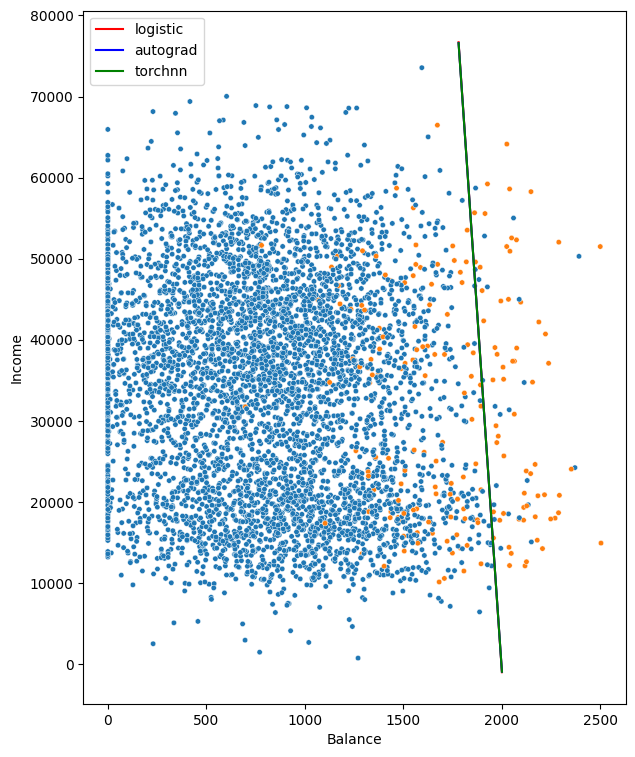

In [156]:
plt.figure(figsize = (7, 9))
scatter = sns.scatterplot(data = df2, x = 'balance', y = 'income', s = 15, hue = 'default', legend = False)

handles, labels = scatter.get_legend_handles_labels()
without_default = [(h, l) for h, l in zip(handles, labels) if l != 'default']
plt.legend(*zip(*without_default), title = 'Legend')

plt.plot(df2['x_grid'], df2['bdb_logistic'], color='red', label='logistic')
plt.plot(df2['x_grid'], df2['bdb_autograd'], color='blue', label='autograd')
plt.plot(df2['x_grid'], df2['bdb_torchnn'], color='green', label='torchnn')

# Add labels and legend
plt.xlabel('Balance')
plt.ylabel('Income')
plt.legend(loc='upper left')

# Show the plot
plt.show()